# Libraries

In [89]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

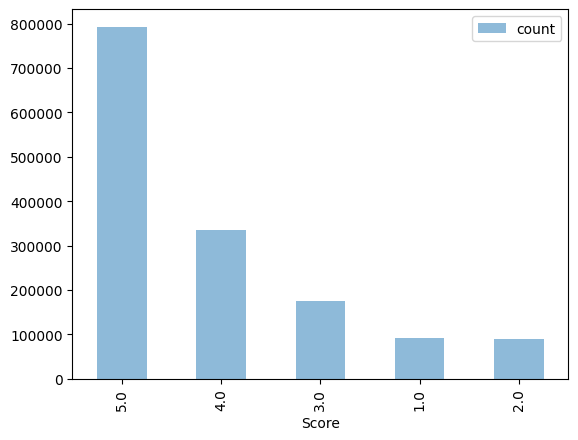


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [90]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")


# Adding Features

In [91]:
def add_features_to(df):
    # Calculate helpfulness ratio
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    
    return df

# Load or process the data
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    
    # Merge for submission set
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    
    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]
    
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [92]:

print("Processing data...")

# Define numerical features to use
numerical_features = [
    'HelpfulnessNumerator',
    'HelpfulnessDenominator',
    'Time',
    'Helpfulness'
]

# Split data into features and target
X = X_train[numerical_features]  # Only select numerical features
y = X_train['Score']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)



Processing data...


# Feature Selection

In [93]:

print("Scaling features...")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Scaling features...


# Model Creation

In [94]:

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

# Fit the grid search
grid_search.fit(X_train_scaled, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Get best model
best_rf = grid_search.best_estimator_

# Make predictions with best model
y_pred = best_rf.predict(X_test_scaled)


# Model Evaluation

Accuracy: 0.545503263890385


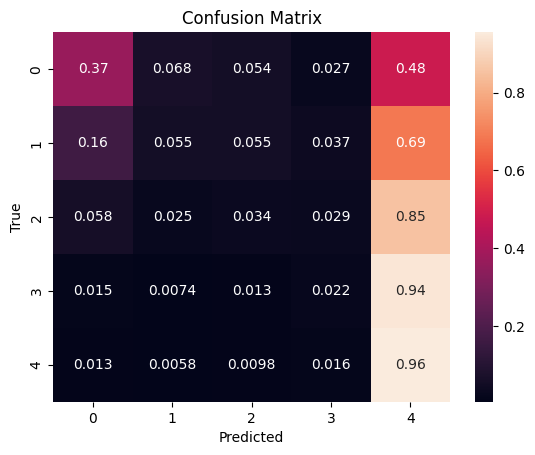

In [95]:

# Evaluate your model on the testing set
print("Accuracy:", accuracy_score(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [96]:
# Create submission predictions
X_submission_scaled = scaler.transform(X_submission[numerical_features])
X_submission['Score'] = rf_model.predict(X_submission_scaled)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

# Print feature importances
feature_importance = pd.DataFrame({
    'feature': numerical_features,
    'importance': rf_model.feature_importances_
})
print("\nFeature Importances:")
print(feature_importance.sort_values('importance', ascending=False))


Feature Importances:
                  feature  importance
2                    Time    0.509471
3             Helpfulness    0.229983
1  HelpfulnessDenominator    0.204160
0    HelpfulnessNumerator    0.056385
